In [87]:
import json

import arviz as az
import cmasher as cmr
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xgi
from cycler import cycler

import fig_settings as fs
from lcs import *

# Set the global default size of the axis labels
plt.rcParams["axes.labelsize"] = 20
# Set the global default size of the tick labels
plt.rcParams["xtick.labelsize"] = 15
plt.rcParams["ytick.labelsize"] = 15
plt.rcParams["axes.titlesize"] = 25
plt.rcParams["legend.fontsize"] = 15
plt.rcParams["xtick.major.size"] = 7  # length in points

In [88]:
# pallete = ["#F8B195","#355C7D","#F67280","#C06C84","#6C5B7B"]
pallete = ["#355C7D", "#F67280", "#F8B195", "#C06C84", "#6C5B7B"]
mpl.rcParams["axes.prop_cycle"] = mpl.cycler(color=pallete)
cmap = mcolors.LinearSegmentedColormap.from_list("my_cmap", [pallete[0], pallete[1]])

In [89]:
fs.set_fonts()

/Users/willthompson/miniconda3/envs/complex_inference/lib/python3.11/site-packages/xgi/drawing/draw.py:386: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


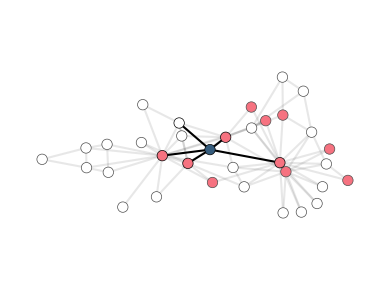

In [90]:
el = zkc(format="edgelist")
H = xgi.Hypergraph(el)
A = zkc()
n = A.shape[0]

i = 13
t = 56

gamma = 0.2
b = 0.07
contagion_function = lambda nu, b: 1 - (1 - b) ** nu
c = contagion_function(np.arange(n), b)
x0 = np.zeros(n)
x0[0] = 1

x = contagion_process(A, gamma, c, x0, tmin=0, tmax=100, random_seed=2)

infected_color = "C1"
susceptible_color = "white"
subgraph_color = "black"
graph_color = (0.1, 0.1, 0.1, 0.1)
subgraph_node_lc = "black"
graph_node_lc = (0.3, 0.3, 0.3)

sg = H.nodes.memberships(i)
nbrs = H.nodes.neighbors(i)
nbrs.add(i)

pos = xgi.pca_transform(xgi.pairwise_spring_layout(H, seed=5, k=0.3))
node_fc = [infected_color if x[t, i] else susceptible_color for i in H.nodes]
node_ec = [subgraph_node_lc if n in nbrs else graph_node_lc for n in H.nodes]
node_fc[12] = "C0"

dyad_color = [subgraph_color if e in sg else graph_color for e in H.edges]

plt.figure(figsize=(4, 3))


xgi.draw(
    H,
    pos=pos,
    node_size=7.5,
    node_fc=node_fc,
    dyad_color=dyad_color,
    node_ec=node_ec,
    node_lw=0.5,
)

plt.tight_layout()
plt.savefig("Figures/Fig1/zkc_network.svg", dpi=1000)
plt.savefig("Figures/Fig1/zkc_network.png", dpi=1000)
plt.show()

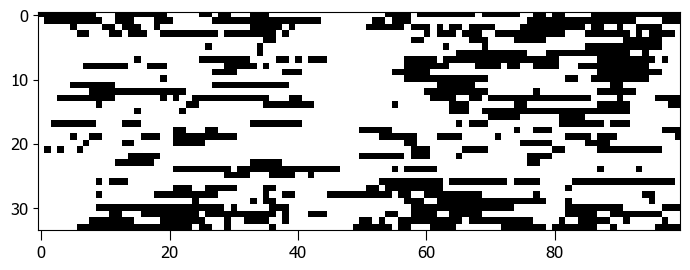

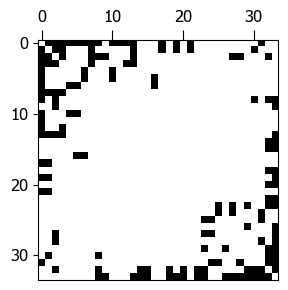

In [91]:
# Plot matrices
plt.figure(figsize=(7, 3))
plt.imshow(x.T, cmap=cm.Greys, vmin=0, vmax=1, interpolation="none")
plt.yticks([0, 10, 20, 30])

plt.tight_layout()
plt.savefig("Figures/Fig1/x.svg", dpi=1000)
plt.savefig("Figures/Fig1/x.png", dpi=1000)
plt.show()

plt.figure(figsize=(3, 3))
plt.imshow(A, vmin=0, vmax=1, cmap=cm.Greys, interpolation="none")
plt.xticks([0, 10, 20, 30])
plt.yticks([0, 10, 20, 30])
ax = plt.gca()
ax.xaxis.tick_top()

plt.tight_layout()
plt.savefig("Figures/Fig1/a.svg", dpi=1000)
plt.savefig("Figures/Fig1/a.png", dpi=1000)
plt.show()

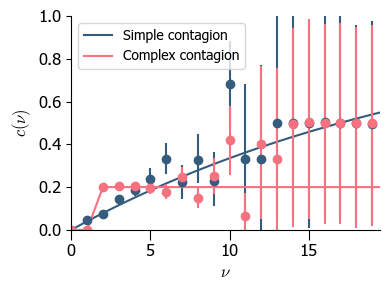

In [92]:
with open("Data/zkc_infer_contagion_functions.json") as file:
    data = json.load(file)

A = np.array(data["A"], dtype=float)
c1 = np.array(data["c1"], dtype=float)
c2 = np.array(data["c2"], dtype=float)
x1 = np.array(data["x1"], dtype=int)
x2 = np.array(data["x2"], dtype=int)
A1_samples = np.array(data["A1-samples"], dtype=int)
A2_samples = np.array(data["A2-samples"], dtype=int)
gamma1_samples = np.array(data["gamma1-samples"], dtype=float)
gamma2_samples = np.array(data["gamma2-samples"], dtype=float)
c1_samples = np.array(data["c1-samples"], dtype=float)
c2_samples = np.array(data["c2-samples"], dtype=float)
l1 = np.array(data["l1"], dtype=float)
l2 = np.array(data["l2"], dtype=float)

# import cmasher as cmr
# cmap = cmr.ember
colors = pallete

kmax = np.max(degrees(A))
n = A.shape[0]

nus = np.arange(0, n, 1)

plt.figure(figsize=(4, 3))

# simple contagion
c1_mean = c1_samples.mean(axis=0)
plt.plot(nus, c1, "-", color="C0", label="Simple contagion")
# plt.scatter(nus, c1_mean, linewidth=0.5, color=colors[2])

err_c1 = np.zeros((2, n))
c1_mode = np.zeros(n)
for i in range(n):
    interval = az.hdi(c1_samples[:, i], hdi_prob=0.95)
    x, y = interval
    err_c1[0, i] = max(c1_mean[i] - x, 0)
    err_c1[1, i] = max(y - c1_mean[i], 0)
plt.errorbar(nus, c1_mean, err_c1, color="C0", fmt="o")

# threshold contagion, tau=2
c2_mean = c2_samples.mean(axis=0)
plt.plot(nus, c2, "-", color="C1", label="Complex contagion")
# plt.scatter(nus, c2_mean, linewidth=0.5, color=colors[1])

err_c2 = np.zeros((2, n))
c2_mode = np.zeros(n)
for i in range(n):
    interval = az.hdi(c2_samples[:, i], alpha=0.05, roundto=4)
    x, y = interval
    err_c2[0, i] = max(c2_mean[i] - x, 0)
    err_c2[1, i] = max(y - c2_mean[i], 0)
plt.errorbar(nus, c2_mean, err_c2, color="C1", fmt="o")

plt.xticks(np.arange(0, n, 5))
plt.xlabel(r"$\nu$")
plt.ylabel(r"$c(\nu)$")


plt.xlim([0, kmax + 2.5])
plt.ylim([0, 1])

plt.legend(loc="upper left")

sns.despine()
plt.tight_layout()


plt.savefig("Figures/Fig1/zkc_infer_contagion_function.svg", dpi=1000)
plt.savefig("Figures/Fig1/zkc_infer_contagion_function.png", dpi=1000)
plt.show()

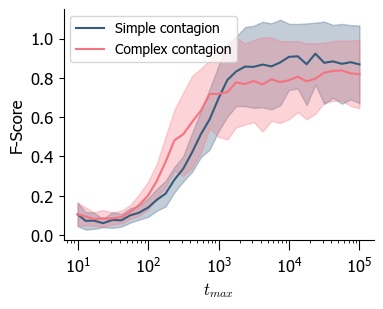

In [93]:
with open("Data/zkc_infer_vs_tmax.json") as file:
    data = json.load(file)

# colors = ["steelblue", "darksalmon", "mediumseagreen"]
colors = pallete

tmax = data["tmax"]
sps = np.array(data["sps"], dtype=float)
ps = np.array(data["ps"], dtype=float)
fce = np.array(data["fce"], dtype=float)

fig = plt.figure(figsize=(4, 3))

# plt.semilogx(tmax, sps[0].mean(axis=1), color=colors[2], label="Simple contagion")
plt.semilogx(tmax, sps[0].mean(axis=1), color="C0", label="Simple contagion")
plt.semilogx(tmax, sps[1].mean(axis=1), color="C1", label="Complex contagion")
plt.fill_between(
    tmax,
    sps[0].mean(axis=1) - sps[0].std(axis=1),
    sps[0].mean(axis=1) + sps[0].std(axis=1),
    alpha=0.3,
    color="C0",
)
plt.fill_between(
    tmax,
    sps[1].mean(axis=1) - sps[1].std(axis=1),
    sps[1].mean(axis=1) + sps[1].std(axis=1),
    alpha=0.3,
    color="C1",
)
plt.ylabel("F-Score")
plt.xlabel(r"$t_{max}$")

plt.legend(loc="upper left")
sns.despine()

plt.savefig("Figures/Fig1/zkc_infer_vs_tmax.svg", dpi=1000)
plt.savefig("Figures/Fig1/zkc_infer_vs_tmax.png", dpi=1000)
plt.show()

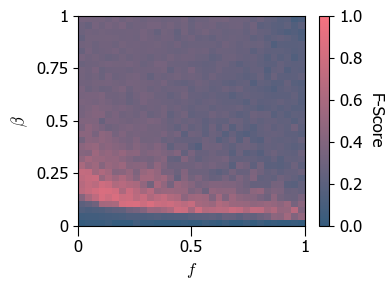

In [94]:
with open("Data/zkc_frac_vs_beta.json") as file:
    data = json.load(file)
beta = np.array(data["beta"], dtype=float)
frac = np.array(data["fraction"], dtype=float)
ps = np.array(data["ps"], dtype=float)
sps = np.array(data["sps"], dtype=float)
fce = np.array(data["fce"], dtype=float)

# cmap = cmr.gem
cmap = cmap

sps_summary = sps.mean(axis=2)

fig = plt.figure(figsize=(4, 3))

c = plt.imshow(
    to_imshow_orientation(sps_summary),
    extent=(min(frac), max(frac), min(beta), max(beta)),
    aspect="auto",
    cmap=cmap,
    vmin=0,
    vmax=1,
)
plt.xlabel(r"$f$")
plt.ylabel(r"$\beta$")

plt.xticks([0, 0.5, 1], [0, 0.5, 1])
plt.yticks([0, 0.25, 0.5, 0.75, 1], [0, 0.25, 0.5, 0.75, 1])

cbar = plt.colorbar(c)
cbar.set_label(r"F-Score", fontsize=12, rotation=270, labelpad=15)
plt.tight_layout()

plt.savefig("Figures/Fig1/zkc_frac_vs_beta.svg", dpi=1000)
plt.savefig("Figures/Fig1/zkc_frac_vs_beta.png", dpi=1000)
plt.show()

/Users/willthompson/miniconda3/envs/complex_inference/lib/python3.11/site-packages/xgi/drawing/draw.py:386: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


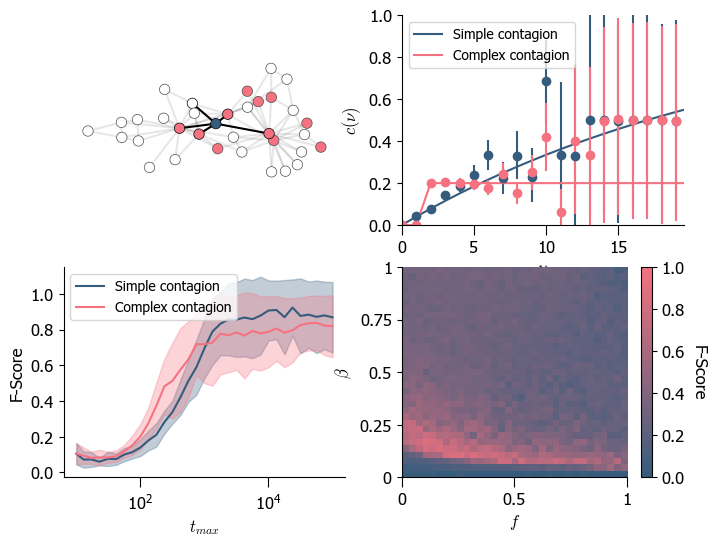

In [97]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(
    2, 2, figsize=(8, 6), sharey=False, sharex=False
)

"""
Panel 1: Network Viz
"""
el = zkc(format="edgelist")
H = xgi.Hypergraph(el)
A = zkc()
n = A.shape[0]

i = 13
t = 56

gamma = 0.2
b = 0.07
contagion_function = lambda nu, b: 1 - (1 - b) ** nu
c = contagion_function(np.arange(n), b)
x0 = np.zeros(n)
x0[0] = 1

x = contagion_process(A, gamma, c, x0, tmin=0, tmax=100, random_seed=2)

infected_color = "C1"
susceptible_color = "white"
subgraph_color = "black"
graph_color = (0.1, 0.1, 0.1, 0.1)
subgraph_node_lc = "black"
graph_node_lc = (0.3, 0.3, 0.3)

sg = H.nodes.memberships(i)
nbrs = H.nodes.neighbors(i)
nbrs.add(i)

pos = xgi.pca_transform(xgi.pairwise_spring_layout(H, seed=5, k=0.3))
node_fc = [infected_color if x[t, i] else susceptible_color for i in H.nodes]
node_ec = [subgraph_node_lc if n in nbrs else graph_node_lc for n in H.nodes]
node_fc[12] = "C0"

dyad_color = [subgraph_color if e in sg else graph_color for e in H.edges]


xgi.draw(
    H,
    pos=pos,
    node_size=7.5,
    node_fc=node_fc,
    dyad_color=dyad_color,
    node_ec=node_ec,
    node_lw=0.5,
    ax=ax1,
)

# plt.savefig("Figures/Fig1/zkc_network.svg", dpi=1000)
# plt.savefig("Figures/Fig1/zkc_network.png", dpi=1000)


"""
Panel 2: 
"""


with open("Data/zkc_infer_contagion_functions.json") as file:
    data = json.load(file)

A = np.array(data["A"], dtype=float)
c1 = np.array(data["c1"], dtype=float)
c2 = np.array(data["c2"], dtype=float)
x1 = np.array(data["x1"], dtype=int)
x2 = np.array(data["x2"], dtype=int)
A1_samples = np.array(data["A1-samples"], dtype=int)
A2_samples = np.array(data["A2-samples"], dtype=int)
gamma1_samples = np.array(data["gamma1-samples"], dtype=float)
gamma2_samples = np.array(data["gamma2-samples"], dtype=float)
c1_samples = np.array(data["c1-samples"], dtype=float)
c2_samples = np.array(data["c2-samples"], dtype=float)
l1 = np.array(data["l1"], dtype=float)
l2 = np.array(data["l2"], dtype=float)

# import cmasher as cmr
# cmap = cmr.ember

kmax = np.max(degrees(A))
n = A.shape[0]

nus = np.arange(0, n, 1)

# simple contagion
c1_mean = c1_samples.mean(axis=0)
ax2.plot(nus, c1, "-", color="C0", label="Simple contagion")
# ax2.scatter(nus, c1_mean, linewidth=0.5, color=colors[2])

err_c1 = np.zeros((2, n))
c1_mode = np.zeros(n)
for i in range(n):
    interval = az.hdi(c1_samples[:, i], hdi_prob=0.95)
    x, y = interval
    err_c1[0, i] = max(c1_mean[i] - x, 0)
    err_c1[1, i] = max(y - c1_mean[i], 0)
ax2.errorbar(nus, c1_mean, err_c1, color="C0", fmt="o")

# threshold contagion, tau=2
c2_mean = c2_samples.mean(axis=0)
ax2.plot(nus, c2, "-", color="C1", label="Complex contagion")
# ax2.scatter(nus, c2_mean, linewidth=0.5, color=colors[1])

err_c2 = np.zeros((2, n))
c2_mode = np.zeros(n)
for i in range(n):
    interval = az.hdi(c2_samples[:, i], alpha=0.05, roundto=4)
    x, y = interval
    err_c2[0, i] = max(c2_mean[i] - x, 0)
    err_c2[1, i] = max(y - c2_mean[i], 0)
ax2.errorbar(nus, c2_mean, err_c2, color="C1", fmt="o")

ax2.set_xticks(np.arange(0, n, 5))
ax2.set_xlabel(r"$\nu$")
ax2.set_ylabel(r"$c(\nu)$")


ax2.set_xlim([0, kmax + 2.5])
ax2.set_ylim([0, 1])

ax2.legend(loc="upper left")

sns.despine()


# # ax2.savefig("Figures/Fig1/zkc_infer_contagion_function.svg", dpi=1000)
# # ax2.savefig("Figures/Fig1/zkc_infer_contagion_function.png", dpi=1000)
# ax2.show()

with open("Data/zkc_infer_vs_tmax.json") as file:
    data = json.load(file)

# colors = ["steelblue", "darksalmon", "mediumseagreen"]
colors = pallete

tmax = data["tmax"]
sps = np.array(data["sps"], dtype=float)
ps = np.array(data["ps"], dtype=float)
fce = np.array(data["fce"], dtype=float)


# ax3.semilogx(tmax, sps[0].mean(axis=1), color=colors[2], label="Simple contagion")
ax3.semilogx(tmax, sps[0].mean(axis=1), color="C0", label="Simple contagion")
ax3.semilogx(tmax, sps[1].mean(axis=1), color="C1", label="Complex contagion")
ax3.fill_between(
    tmax,
    sps[0].mean(axis=1) - sps[0].std(axis=1),
    sps[0].mean(axis=1) + sps[0].std(axis=1),
    alpha=0.3,
    color="C0",
)
ax3.fill_between(
    tmax,
    sps[1].mean(axis=1) - sps[1].std(axis=1),
    sps[1].mean(axis=1) + sps[1].std(axis=1),
    alpha=0.3,
    color="C1",
)
ax3.set_ylabel("F-Score")
ax3.set_xlabel(r"$t_{max}$")

ax3.legend(loc="upper left")
sns.despine()


with open("Data/zkc_frac_vs_beta.json") as file:
    data = json.load(file)
beta = np.array(data["beta"], dtype=float)
frac = np.array(data["fraction"], dtype=float)
ps = np.array(data["ps"], dtype=float)
sps = np.array(data["sps"], dtype=float)
fce = np.array(data["fce"], dtype=float)

# cmap = cmr.gem
cmap = cmap

sps_summary = sps.mean(axis=2)


c = ax4.imshow(
    to_imshow_orientation(sps_summary),
    extent=(min(frac), max(frac), min(beta), max(beta)),
    aspect="auto",
    cmap=cmap,
    vmin=0,
    vmax=1,
)
ax4.set_xlabel(r"$f$")
ax4.set_ylabel(r"$\beta$")

ax4.set_xticks([0, 0.5, 1], [0, 0.5, 1])
ax4.set_yticks([0, 0.25, 0.5, 0.75, 1], [0, 0.25, 0.5, 0.75, 1])

cbar = plt.colorbar(c, ax=ax4)
cbar.set_label(r"F-Score", fontsize=12, rotation=270, labelpad=15)